In [ ]:
# CNN Enhanced_Model [DenseNet201] on SkinCancerDisease Diseases Detection¬##

In [1]:
import pathlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL

from glob import glob
from IPython.display import SVG
import PIL as image_lib
from tensorflow.keras.layers import GlobalAveragePooling2D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/DataSets/skincancer/data/train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/DataSets/skincancer/data/test")

In [3]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2637
660


Found 2637 files belonging to 2 classes.


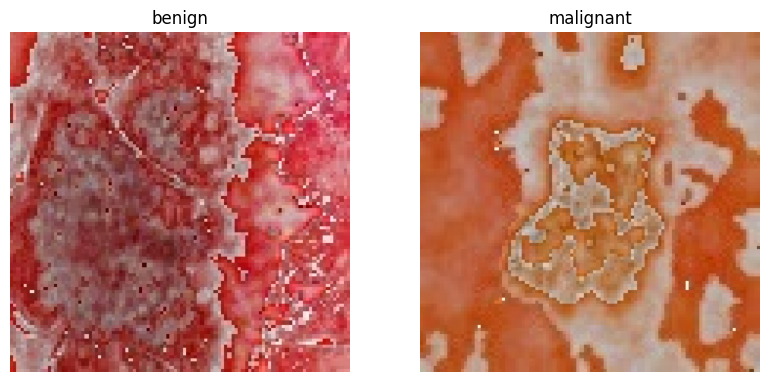

In [4]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,image_size=(224,224),
                                                                    label_mode='categorical',seed=123)

#all the classes of plants
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(224,224)))
    plt.title(c)
    plt.axis("off")

In [5]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,malignant,1197
1,benign,1440


<Axes: xlabel='No. of Image', ylabel='Class'>

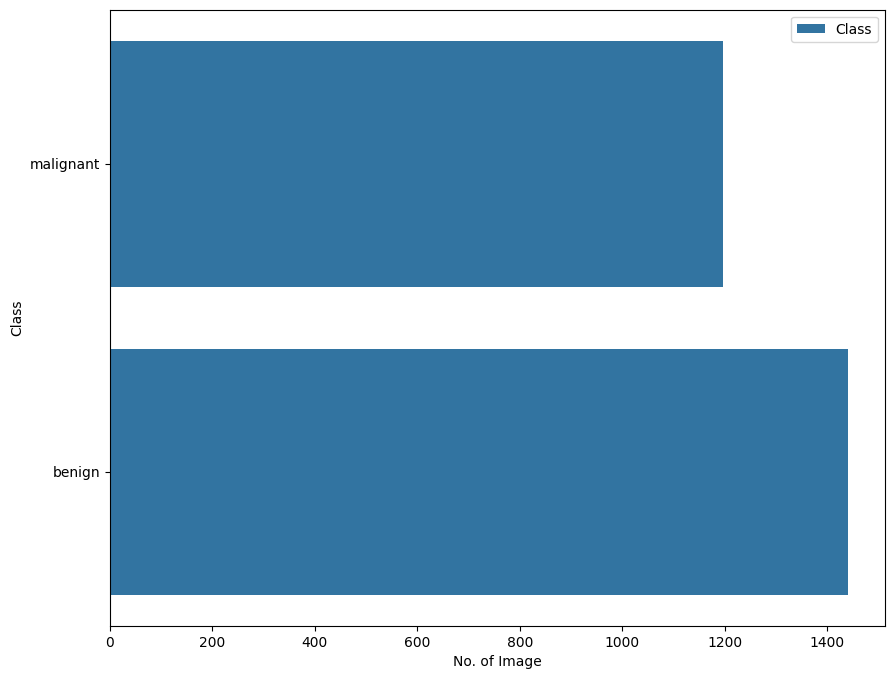

In [6]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8)  )
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [7]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=64,
                                                               image_size=(224,224), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,
                                                            image_size=(224,224), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [8]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Initialize the DenseNet201 Sequential model
# Load the DenseNet201 model pretrained on ImageNet without including the top classification layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers in the base model to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
densenet201_model = Sequential()

# Add the base DenseNet201 model
densenet201_model.add(base_model)

# Add a global average pooling layer to reduce the spatial dimensions of the features
densenet201_model.add(GlobalAveragePooling2D())

# Add a fully connected layer with 512 units and ReLU activation
densenet201_model.add(Dense(512, activation='relu'))

# Add the output layer with the appropriate number of units for your classification task
densenet201_model.add(Dense(2, activation='softmax'))
# Print a summary of the model architecture
densenet201_model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 19306562 (73.65 MB)
Trainable params: 984578 (3.76 MB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


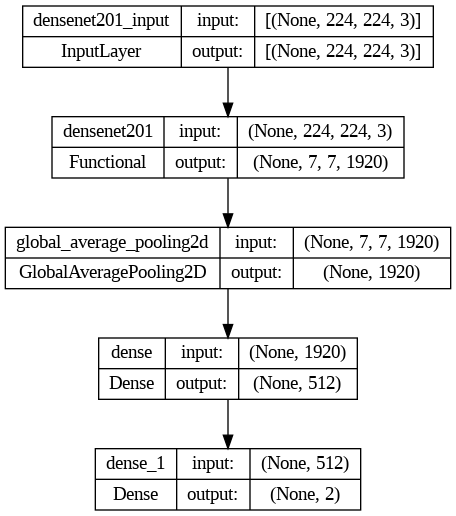

In [10]:
# vizualizing the model
plot_model(densenet201_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
#Compile the Model
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

densenet201_model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [12]:
# Train the model
history = densenet201_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[checkpoint, earlystop])

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 2.4934 - accuracy: 0.6782 
Epoch 1: val_accuracy improved from -inf to 0.71537, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1008s 25s/step - loss: 2.4934 - accuracy: 0.6782 - val_loss: 0.8518 - val_accuracy: 0.7154
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.7701 
Epoch 2: val_accuracy improved from 0.71537 to 0.77419, saving model to model.h5
33/33 [==============================] - 820s 25s/step - loss: 0.6009 - accuracy: 0.7701 - val_loss: 0.5076 - val_accuracy: 0.7742
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.7915 
Epoch 3: val_accuracy improved from 0.77419 to 0.79317, saving model to model.h5
33/33 [==============================] - 826s 25s/step - loss: 0.4852 - accuracy: 0.7915 - val_loss: 0.5236 - val_accuracy: 0.7932
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8104 
Epoch 4: val_accuracy improved from 0.79317 to 0.80076, saving model to model.h5
33/33 [==============================] - 824s 25s/step - loss: 0.4212 - accura

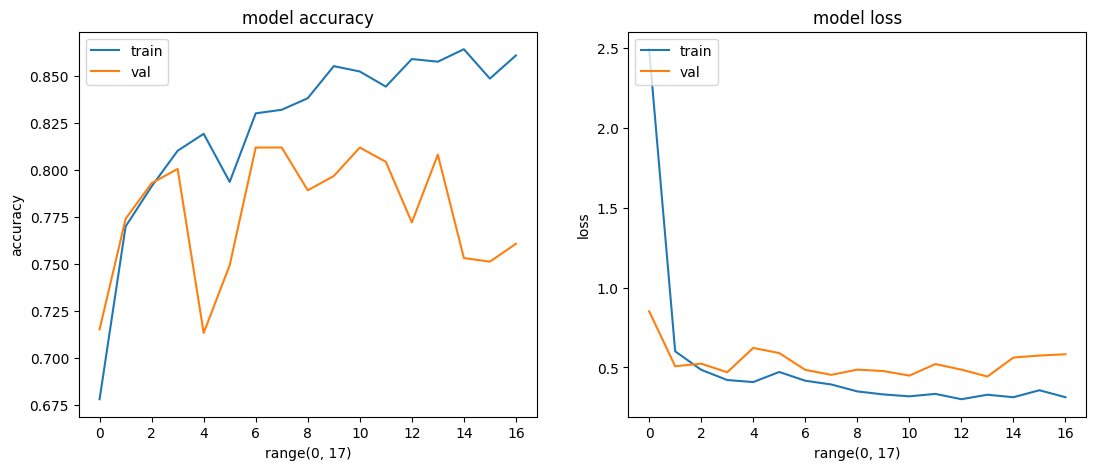

In [13]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 4s 4s/step
Actual Class : malignant

Predictive Class : malignant



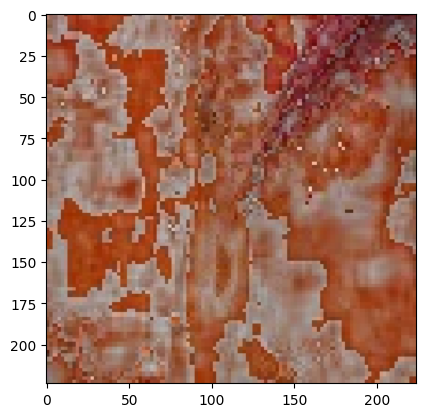

In [14]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(224,224))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = densenet201_model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class : "+ class_names[1] +'\n\n'+ "Predictive Class : "+pred_class +'\n' )